## References

### Baseline code

[1] https://www.kaggle.com/ahmedaffan789/bert-toxic-comments-pytorch

#### Text Normalization

[2] https://gist.github.com/seanh/0a56cd528714496625662dd9136d0cd3

[4] https://towardsdatascience.com/text-normalization-for-natural-language-processing-nlp-70a314bfa646


In [22]:
import torch
import pandas as pd
import seaborn as sns

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

In [25]:
# Load dataset
train_df = pd.read_csv('dataset/train.tsv', sep='\t')
train_df

,PID,Text_data,Label
0,train_pid_1,Waiting for my mind to have a breakdown once t...,moderate
1,train_pid_2,My new years resolution : I'm gonna get my ass...,moderate
2,train_pid_3,New year : Somone else Feeling like 2020 will ...,moderate
3,train_pid_4,"My story I guess : Hi, Im from Germany and my ...",moderate
4,train_pid_5,Sat in the dark and cried myself going into th...,moderate
...,...,...,...
8886,train_pid_8887,Ways to reverse memory loss from depression? :...,severe
8887,train_pid_8888,A Comprehensive Guide To Slowly Getting Better...,severe
8888,train_pid_8889,I don’t think college is right for me : TW: su...,severe
8889,train_pid_8890,Please help: Severe insomnia affecting me in m...,severe


In [26]:
train_df, val_df = train_test_split(train_df, test_size=0.3, random_state=2020)
train_df.to_csv('dataset/train_80.tsv', sep='\t', index=False)
val_df.to_csv('dataset/dev_20.tsv', sep='\t', index=False)

In [ ]:
_ = sns.countplot(train_df.Label)

In [ ]:
# Up sampling
severe_df = train_df[train_df.Label == 'severe'].sample(3000, replace=True)

ndepress_df = train_df[train_df.Label == 'not depression'].sample(3000, replace=True)

moderate_df = train_df[train_df.Label == 'moderate'].sample(3000, replace=True)

In [ ]:
train_df = pd.concat([moderate_df, ndepress_df, severe_df])

In [ ]:
train_df = train_df.reset_index(drop=True)

In [ ]:
train_df.to_csv('dataset/train_upsampling.tsv', sep='\t', index=False)

/home/congvm/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Label', ylabel='count'>

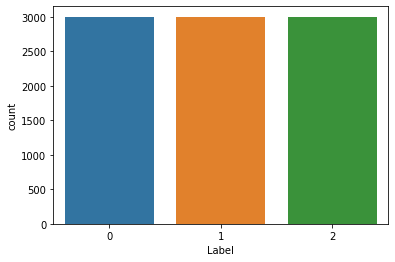

In [19]:
import pandas as pd

df = pd.read_csv('dataset/train_prepr.tsv', sep='\t')
sns.countplot(df.Label)

In [ ]:
# Deep Learning
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR

# NLP
from transformers import AutoTokenizer, AutoModel

# Random Seed Initialize
RANDOM_SEED = 42


def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything()

# Device Optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

In [ ]:
contractions_dict = {
    "y'know": "you know",
    "ain't": "are not",
    "'s": " is",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "cant": "can not",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "that'd": "that would",
    "that'd've": "that would have",
    "there'd": "there would",
    "there'd've": "there would have",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what've": "what have",
    "when've": "when have",
    "where'd": "where did",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who've": "who have",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
    "isn't": "is not",
    "wasn't": "was not",
    "aren't": "are not",
    "weren't": "were not",
    "can't": "can not",
    "couldn't": "could not",
    "don't": "do not",
    "didn't": "did not",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "doesn't": "does not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "won't": "will not",
    "doesn't": "does not",
    "don't": "do not",
    "gotta": "have to",
    "gonna": "going to",
    "wanna": "want to",
    "what's": "what is",
    "what're": "what are",
    "who's": "who is",
    "who're": "who are",
    "where's": "where is",
    "where're": "where are",
    "when's": "when is",
    "when're": "when are",
    "how's": "how is",
    "how're": "how are",
    "I'm": "i am",
    "we're": "we are",
    "you're": "you are",
    "they're": "they are",
    "it's": "it is",
    "he's": "he is",
    "she's": "she is",
    "that's": "that is",
    "there's": "there is",
    "there're": "there are",
    "I've": "i have",
    "we've": "we have",
    "you've": "you have",
    "they've": "they have",
    "who've": "who have",
    "would've": "would have",
    "not've": "not have",
    "I'll": "I will",
    "we'll": "we will",
    "you'll": "you will",
    "he'll": "he will",
    "she'll": "she will",
    "it'll": "it will",
    "they'll": "they will",
    "isn't": "is not",
    "wasn't": "was not",
    "aren't": "are not",
    "weren't": "were not",
    "can't": "can not",
    "couldn't": "could not",
    "don't": "do not",
    "didn't": "did not",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "doesn't": "does not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "won't": "will not",
}


## Text preprocessing

Text preprocessing steps include a few essential tasks to further clean the available text data. It includes tasks like:-

1. Stop-Word Removal : In English words like a, an, the, as, in, on, etc. are considered as stop-words so according to our requirements we can remove them to reduce vocabulary size as these words don't have some specific meaning

2. Lower Casing : Convert all words into the lower case because the upper or lower case may not make a difference for the problem. And we are reducing vocabulary size by doing so.

3. Stemming : Stemming refers to the process of removing suffixes and reducing a word to some base form such that all different variants of that word can be represented by the same form (e.g., “walk” and “walking” are both reduced to “walk”).

4. Tokenization : NLP software typically analyzes text by breaking it up into words (tokens) and sentences.

In [ ]:
# 'no' in stopwords

In [ ]:
import re
from bs4 import BeautifulSoup
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = stopwords.words('english')

# Why "not" a stopword
# https://datascience.stackexchange.com/questions/15765/nlp-why-is-not-a-stop-word
# Remove 'not' from stopwords
keep_words = ['not', 'no']
for w in keep_words:
    stopwords.remove(w)


def remove_stopwords(text: str, stopwords: list):
    pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
    text = pattern.sub('', text)
    return text


def remove_website_links(text):
    template = re.compile(r'https?://\S+|www\.\S+')  # Removes website links
    text = template.sub(r'', text)
    return text


def remove_html_tags(text: str):
    soup = BeautifulSoup(text, 'html.parser')  # Removes HTML tags
    return soup.get_text()


def remove_emoji(text: str):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text


def expand_contractions(s, contractions_dict: dict = contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]

    contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
    return contractions_re.sub(replace, s)


def text_cleaning(paragraph):
    '''
    Cleans text into a basic form for NLP. Operations include the following:-
    0. Lower case
    1. Remove special charecters like &, #, etc
    2. Removes extra spaces
    3. Removes embedded URL links
    4. Removes HTML tags
    5. Removes emojis
    
    text - Text piece to be cleaned.
    '''

    paragraph = paragraph.lower()
    paragraph = re.sub(r"’", "'", paragraph)
    paragraph = remove_website_links(paragraph)
    paragraph = remove_html_tags(paragraph)
    paragraph = remove_emoji(paragraph)

    # paragraph = paragraph.replace('.', ' .')
    # paragraph = re.sub(r"[^...]", " ", paragraph)
    # paragraph = re.sub(r"[^a-zA-Z\d]", " ", paragraph)  # Remove special Charecters
    sents = nltk.sent_tokenize(paragraph)
    # paragraph = paragraph.replace(' .', '.')
    
    # return sents

    for i in range(len(sents)):
        sent = sents[i]
        sent = expand_contractions(sent, contractions_dict)
        sent = remove_stopwords(sent, stopwords)
        sent = re.sub(r"[^a-zA-Z\d]", " ", sent)  # Remove special Charecters
        sent = re.sub(' +', ' ', sent)  # Remove Extra Spaces
        sent = sent.strip()
        sents[i] = sent

    paragraph = ' [SEP] '.join(sents)
    # paragraph = '<s> ' + paragraph + ' </s>'
    return paragraph

In [ ]:
train_df.iloc[0].Text_data

In [ ]:
text_cleaning(train_df.iloc[0].Text_data)

In [ ]:
# nltk.sent_tokenize('last year, i tried not to have any breakdowns for the start of 2019 .3 .4 . a mere 10 days later, i broke down crying.')

In [ ]:
tqdm.pandas()
train_df.Text_data = train_df.Text_data.progress_apply(text_cleaning)

In [ ]:
train_df.sample(10)

In [ ]:
max(train_df.Text_data.apply(lambda x: len(x.split())))

In [ ]:
import matplotlib.pyplot as plt

_ = plt.hist(train_df.Text_data.apply(lambda x: len(x.split())), bins=100)

In [ ]:
sns.countplot(train_df.Label)

In [ ]:
tqdm.pandas()
# Load dataset
train_df = pd.read_csv('dataset/train.tsv', sep='\t')
dev_df = pd.read_csv('dataset/dev_with_labels.tsv', sep='\t')
dev_df = dev_df.rename(columns={'Text data': 'Text_data'})

train_df.Text_data = train_df.Text_data.progress_apply(text_cleaning)
dev_df.Text_data = dev_df.Text_data.progress_apply(text_cleaning)


In [ ]:
dev_df

In [ ]:
params = {
    'device': device,
    'debug': False,
    'checkpoint': 'bert-base-uncased',  #'allenai/longformer-base-4096',
    'output_logits': 768,
    'max_len': 512,
    'batch_size': 32,
    'dropout': 0.2,
    'num_workers': 2
}

In [ ]:
# from transformers import LongformerModel, LongformerTokenizer
from transformers import BertTokenizer

from torch.utils.data import DataLoader, Dataset

In [ ]:
tokenizer = BertTokenizer.from_pretrained(params['checkpoint'])

In [ ]:
train_df.Text_data.iloc[0]

In [ ]:
tokenizer

In [ ]:
encoded_text = tokenizer.encode(train_df.Text_data.iloc[0])
print(encoded_text)

In [ ]:
decoded_text = tokenizer.decode(encoded_text)
print(decoded_text)

In [ ]:
class TextEDIDataset(Dataset):
    def __init__(self,
                 text_df: pd.DataFrame,
                 max_len: int = params['max_len'],
                 checkpoint: str = params['checkpoint'],
                 is_training=True):
        super().__init__()
        self.is_training = is_training
        self.text_df = text_df
        self.max_len = max_len
        self.checkpoint = checkpoint
        self.tokenizer = BertTokenizer.from_pretrained(checkpoint)
        self.label_mapping = {'moderate': 0, 'not depression': 1, 'severe': 2}

    def __len__(self):
        return len(self.text_df)

    def __getitem__(self, idx):
        text = str(self.text_df.iloc[idx].Text_data)

        tokenized_text = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_attention_mask=True,
            return_token_type_ids=True,
        )

        input_ids = tokenized_text['input_ids']
        attention_mask = tokenized_text['attention_mask']
        token_type_ids = tokenized_text['token_type_ids']

        if self.is_training:
            label = self.label_mapping[str(self.text_df.iloc[idx].Label)]
            return {
                'input_ids': torch.tensor(input_ids, dtype=torch.long),
                'attention_mask': torch.tensor(attention_mask,
                                               dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids,
                                               dtype=torch.long),
                'label': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'input_ids': torch.tensor(input_ids, dtype=torch.long),
                'attention_mask': torch.tensor(attention_mask,
                                               dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids,
                                               dtype=torch.long)
            }

In [ ]:
train_dataset = TextEDIDataset(train_df)
dev_dataset = TextEDIDataset(dev_df)
train_loader = DataLoader(train_dataset,
                          batch_size=params['batch_size'],
                          num_workers=4)
dev_loader = DataLoader(dev_dataset,
                          batch_size=params['batch_size'],
                          num_workers=4)


In [ ]:
from transformers import LongformerModel
from transformers import BertModel


class DepressionModel(nn.Module):
    def __init__(self, checkpoint=params['checkpoint'], params=params):
        super(DepressionModel, self).__init__()
        self.checkpoint = checkpoint
        # self.bert = LongformerModel.from_pretrained(checkpoint, return_dict=False)
        self.model = BertModel.from_pretrained(checkpoint,
                                               gradient_checkpointing=True)
        self.layer_norm = nn.LayerNorm(params['output_logits'])
        self.dropout = nn.Dropout(params['dropout'])
        self.dense = nn.Sequential(nn.Linear(params['output_logits'], 256),
                                   nn.LeakyReLU(negative_slope=0.01),
                                   nn.Dropout(params['dropout']),
                                   nn.Linear(256, 3))

    def forward(self, input_ids, token_type_ids, attention_mask):
        _, pooled_output = self.model(input_ids=input_ids,
                                      token_type_ids=token_type_ids,
                                      attention_mask=attention_mask)
        pooled_output = self.layer_norm(pooled_output)
        pooled_output = self.dropout(pooled_output)
        preds = self.dense(pooled_output)
        return preds

In [ ]:
# model = DepressionModel()
# model = model.to(device)

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from collections import OrderedDict
from transformers import AdamW

from torch.nn import CrossEntropyLoss

In [ ]:
class ModelLightning(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = DepressionModel()
        self.criterion = CrossEntropyLoss()

    def configure_optimizers(self):
        param_optimizer = list(self.model.named_parameters())
        no_decay = ["bias", "gamma", "beta"]
        optimizer_grouped_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer
                    if not any(nd in n for nd in no_decay)
                ],
                "weight_decay_rate":
                0.01
            },
            {
                "params": [
                    p for n, p in param_optimizer
                    if any(nd in n for nd in no_decay)
                ],
                "weight_decay_rate":
                0.0
            },
        ]
        optimizer = AdamW(
            optimizer_grouped_parameters,
            lr=2e-5,
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        labels = batch["label"]
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        token_type_ids = batch["token_type_ids"]

        logits = self.model(
            input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
        )

        loss = self.criterion(logits, labels)
        tqdm_dict = {"train_loss": loss}
        output = OrderedDict({
            "loss": loss,
            "progress_bar": tqdm_dict,
            "log": tqdm_dict
        })

        return output

    def validation_step(self, batch, batch_idx):
        labels = batch["label"]
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        token_type_ids = batch["token_type_ids"]

        logits = self.model(
            input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
        )
        loss = self.criterion(logits, labels)
        labels_hat = torch.argmax(logits, dim=1)

        correct_count = torch.sum(labels == labels_hat)

        if self.on_gpu:
            correct_count = correct_count.cuda(loss.device.index)

        output = OrderedDict({
            "val_loss": loss,
            "correct_count": correct_count,
            "batch_size": len(labels)
        })
        return output

    def validation_end(self, outputs):
        val_acc = sum([out["correct_count"]
                       for out in outputs]).float() / sum(out["batch_size"]
                                                          for out in outputs)
        val_loss = sum([out["val_loss"] for out in outputs]) / len(outputs)
        tqdm_dict = {
            "val_loss": val_loss,
            "val_acc": val_acc,
        }
        result = {
            "progress_bar": tqdm_dict,
            "log": tqdm_dict,
            "val_loss": val_loss
        }
        return result

    def test_step(self, batch, batch_idx):
        labels = batch["label"]
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        token_type_ids = batch["token_type_ids"]

        loss, logits = self.model(input_ids,
                                  token_type_ids=token_type_ids,
                                  attention_mask=attention_mask,
                                  labels=labels)
        labels_hat = torch.argmax(logits, dim=1)

        correct_count = torch.sum(labels == labels_hat)

        if self.on_gpu:
            correct_count = correct_count.cuda(loss.device.index)

        output = OrderedDict({
            "test_loss": loss,
            "correct_count": correct_count,
            "batch_size": len(labels)
        })

        return output

    def test_end(self, outputs):
        test_acc = sum([out["correct_count"]
                        for out in outputs]).float() / sum(out["batch_size"]
                                                           for out in outputs)
        test_loss = sum([out["test_loss"] for out in outputs]) / len(outputs)
        tqdm_dict = {
            "test_loss": test_loss,
            "test_acc": test_acc,
        }
        result = {"progress_bar": tqdm_dict, "log": tqdm_dict}
        return result


In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss",
                                    min_delta=0.0,
                                    patience=3,
                                    verbose=True,
                                    mode="min")

trainer = pl.Trainer(gpus=1, callbacks=[early_stop_callback])

model_lightning = ModelLightning()

trainer.fit(model_lightning,
            train_dataloaders=train_loader,
            val_dataloaders=dev_loader)